# Power Calculations and Experiment Planning

Luopeiwen Yi

When you read about them in a book, power calculations can feel very abstract. To make the concept more concrete, and to give you a chance to familiarize yourself with power calculation tools and the considerations that go into power calculations, in this exercise you will play the role of an experiment planner hired by a Non-Governmental Organization (NGO) named [Bandhan](https://www.bandhan.org/) in West Bengal, India. Bandhan is planning to roll out a program that provides livestock, cash, and some basic training to households in extreme poverty. They hope to demonstrate the value of cash and asset transfers, and so wish their program to take the form of a randomized experiment, with data being collected on both control and treatment households.

Your job will be to help them estimate how many households they should enroll in the program.

This was, in fact, a real program, and so the data you will be working with comes from the actual program (conducted in 2007, with followup data collection in 2010, 2017, and 2020), allowing us to do some retrospective comparison of your power calculations and what actually occurred.

## The Context

> Development economics has long posited that the poor may be poor for no good reason other than the fact that they started poor. This is the idea of a poverty trap, which has the implication that a one-time capital grant that makes very poor households significantly less poor ("big push") might set off a virtuous cycle that takes them out of poverty. Forty-three countries now embrace some version of this idea and make large transfers to over 3.1 million of their poorest households. In particular, the "Targeting the Ultra Poor" (TUP) intervention, pioneered by BRAC in Bangladesh, employs a multifaceted approach, offering poor households an asset transfer, consumption support, savings, and training in the hopes of unlocking a poverty trap.

- [*Long-Term Effects of the Targeting the Ultra Poor Program*](https://economics.mit.edu/research/publications/long-term-effects-targeting-ultra-poor-program), Abhijit Banerjee, Esther Duflo, and Garima Sharma, 2021.

In 2007, Bandhan in West Bengal, India created a pilot program to provide direct, unconditional transfers of productive livestock and a 30 or 40 week stipend of 90 rupees a week (about 7 US dollars a week using the [Purchasing Power Parity (PPP)](https://en.wikipedia.org/wiki/Purchasing_power_parity) exchange rate). The program targeted the poorest households in these villages based on range of criteria, and the average eligible household was later estimated to have a consumption level of about 1.35 2018 US Dollars per capita per day in PPP terms $.^1$

Because the goal of the program was, in significant part, to demonstrate the effect of direct asset transfers, Bandhan identified twice as many eligible households as it could support in the pilot and randomly selected half of the households to act as controls and half to be treated $.^2$ Treated households were offered assets from a menu of options, from the most common choice was productive livestock (e.g., cows and goats). $^3$ Bandhan's contact with the households came to an end 18 months after the households were initially provided their livestock and cash transfers began.

Although data was collected on a huge range of attributes of the households in this program, our focus will be on per capita household expenditures in 2018 US Dollars (PPP). 

(Note that these households certainly were not buying their food with dollars, and in most cases they weren't even buying most of their food with rupees — consumption estimates in this type of study are calculated by collecting detailed data on what household members have consumed in the past week, then estimating the price one would pay to buy those goods in local markets and using [PPP conversion rates](https://en.wikipedia.org/wiki/Purchasing_power_parity) conversion rates to convert that into US Dollars).


In [35]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
from scipy.stats import ttest_ind

warnings.filterwarnings("ignore")

pd.set_option("mode.copy_on_write", True)


## Exercises

### Exercise 1

Load a thinned version of household-level survey data from [Banerjee, Duflo, and Sharma (2021)'s](https://economics.mit.edu/research/publications/long-term-effects-targeting-ultra-poor-program) evaluation of the Bandham program [here](https://github.com/nickeubank/MIDS_Data/tree/master/cash_transfers). 

This is just a version of the replication data for that paper ([which can be found here](https://www.openicpsr.org/openicpsr/project/130362)) with only the variables that are relevant for our analysis.

In [36]:
household_survey = pd.read_csv(
    "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/cash_transfers/TUP_cash_transfers.csv"
)

household_survey.head()

,treatment,pc_exp_month_bl,pc_exp_month_el1,pc_exp_month_el2,pc_exp_month_el3
0,0,37.152084,41.816093,50.286613,60.728490
1,0,19.388021,27.816334,47.899952,88.277290
2,1,33.698770,58.222298,69.547070,69.601420
3,0,26.839483,NaN,NaN,48.802390
4,1,43.763836,45.879470,71.511020,30.258686


### Exercise 2

The first step in doing any power calculations is to establish an estimate of the baseline level of variation that exists in the dependent variable you wish to study. In this case, that variable is Per Capita Monthly Expenditures, and the baseline survey values of expenditures are in `pc_exp_month_bl` (the `_bl` stands for "baseline", meaning this data was collected prior to any households receiving asset transfers and indeed any households being assigned to treatment or control).

What is the mean and standard deviation of `pc_exp_month_bl` in the baseline survey? Divide by 30 to confirm our average household has the expected per capita expenditure level of about US Dollar 1.35 (PPP) a day.

You'll use these quantites a lot, so assign them to variables.

In [37]:
# Calculate the mean of `pc_exp_month_bl`
mean_pc_exp_month_bl = household_survey["pc_exp_month_bl"].mean()
# Caclulate the standard deviation of `pc_exp_month_bl`
std_pc_exp_month_bl = household_survey["pc_exp_month_bl"].std()

print(
    f"The mean of Per Capita Monthly Expenditures is around {round(mean_pc_exp_month_bl,2)}"
)
print(
    f"The standard deviation of Per Capita Monthly Expenditures is around {round(std_pc_exp_month_bl,2)}"
)

# Convert to daily expenditure
mean_daily_bl = mean_pc_exp_month_bl / 30
std_daily_bl = std_pc_exp_month_bl / 30

print(f"The mean of Per Capita Daily Expenditures is around {round(mean_daily_bl,2)}")
print(
    f"The standard deviation of Per Capita Daily Expenditures is around {round(std_daily_bl,2)}"
)

# Assigning the mean and standard deviation of baseline
# monthly expenditures and daily expenditures to variables in the dataframe
household_survey["mean_pc_exp_month_bl"] = mean_pc_exp_month_bl
household_survey["std_pc_exp_month_bl"] = std_pc_exp_month_bl
household_survey["mean_daily_bl"] = mean_daily_bl
household_survey["std_daily_bl"] = std_daily_bl

The mean of Per Capita Monthly Expenditures is around 40.74
The standard deviation of Per Capita Monthly Expenditures is around 24.26
The mean of Per Capita Daily Expenditures is around 1.36
The standard deviation of Per Capita Daily Expenditures is around 0.81


### Exercise 3

For these exercises, we'll use the `power` module in `statsmodels`. [You can read about it here.](https://www.statsmodels.org/stable/stats.html#power-and-sample-size-calculations)

Since we're comparing means in a continuous variable (expenditures) from two samples of households, we will use `TTestIndPower` in `statsmodels.stats.power`. Import this class and instantiate a new instance (for some reason this is class based, so you have to start of with a command like `my_power = TTestIndPower()`). 

Note that a common situation in data science is testing a difference in *proportions* between groups (e.g., across treatment arms). This situation arises when your dependent variable is binary, and so each group's mean is just the share of observations for whom the binary variable is 1. This comes up a lot with apps and websites — e.g., "clicked an ad," "subscribed," "made a purchase." 

For that reason, there's actually a full sub-class of power calculating tools for [proportions you should be aware of.](https://www.statsmodels.org/stable/stats.html#proportion) Basically, because the standard deviation of a binary variable is just $\sqrt{p * (1-p)}$, power calculations become really simple. For example, you may wish to identify the sample size required to get confidence intervals of a given size using a tool like [confint_proportions_2indep](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.confint_proportions_2indep.html#statsmodels.stats.proportion.confint_proportions_2indep).

But the most common use of a power test remains evaluating whether one can reject a null hypothesis of no effect, so we'll start with that here.

In [38]:
# Instantiating a new instance of TTestIndPower
my_power = TTestIndPower()

# Displaying the instance to confirm it's created
my_power

### Exercise 4

[TTestIndPower has three methods](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.TTestIndPower.html#statsmodels.stats.power.TTestIndPower) — `plot_power`, `power`, and `solve_power` — but `solve_power` does everything `power` does, so there are basically two methods.

The idea of `solve_power` is that you give it all but one parameter of a power calculation — minimum detectable effect, number of observations, power, and p-value $\alpha$ threshold — and it will solve for the omitted variable.

To get a quick flavor for how this works, set: 

- Minimal Detectable Effect (`effect_size`) to `0.5` (we'll take about the units of that argument soon), 
- `alpha` to `0.05`, 
- `ratio` to `1` (this is the ratio of between the number of observations being treated and the number in control — in this study, the target was to have these be equal, as that provides the best statistical power for a given total number of observations).
- `power` to `0.8`
- `alternative` to `two-sided` (we want to do a two-tailed t-test, as you could imagine social unrest caused by transfers could make people worse off).
- `nobs1` to `None`. By passing `None`, we're telling `solve_power` this is the quantity we want it to solve for.

So in other words, we're asking:

- how many observations do we need to have in the treatment arm,
- assuming we'll have the same number also in the control arm,
- to have an 80% chance
- of rejecting the null hypothesis of no-effect at a significance threshold of 0.05
- if the true effect is of size 0.5?

What's the answer?

In [39]:
# Using the solve_power method to calculate the number of observations needed in the treatment arm
number_observations = my_power.solve_power(
    effect_size=0.5, alpha=0.05, power=0.8, ratio=1, alternative="two-sided", nobs1=None
)

print(
    f"The number of observations needed in the treatment arm is around {round(number_observations)}"
)

The number of observations needed in the treatment arm is around 64


### Exercise 5

Of all these quantities, perhaps the most obscure is the Minimal Detectable Effect (`effect_size`). What is this 0.5? Where did it come from? And how did you do all that without telling it that standard deviation you had me calculate?

If you check the docs for `solve_power`, you'll see that you're supposed to pass `effect_size` the "standardized effect size, difference between the two means divided by the standard deviation. `effect_size` has to be positive."

In other words, when we passed 0.5, we weren't saying we wanted to be able to detect an effect of 0.5 2018 US Dollars (PPP) per capita per month, we were saying we wanted to detect an effect of 1/2 standard deviation. 

Given the standard deviation in our baseline survey was about 24 Dollars, that means we were saying we wanted to detect an effect size of about 12 US Dollars. 

Is that a lot? Well, the average per capita monthly expenditures in the baseline survey was about 41 Dollars, so it's an increase in expenditures of about 25%. 

OK, but is that what we should use?

Well, the idea of a Minimal Detectable Effect is that you want to set it at a level where (a) if this *was* the real effect when you rejected the null, you'd be happy you did the experiment and, presumably, would be comfortable scaling up the treatment, but also (b) if the true effect were any smaller, you wouldn't want to reject the null hypothesis and scale up the treatment.

Basically, if you set this too high, you may run an under-powered experiment where you miss out on learning that your treatment was effective; if you set this too low, you're spending time and money collecting more data than is probably necessary given you might reject the null at a point estimate where you still wouldn't scale up the treatment.

So what value makes sense here? That's a question you'd want to start off by asking the stakeholders. Since Bandhan wants to use this to promote cash transfers, they probably need the effect to be relatively large to be convincing. Let's assume that, three years after the intervention, they feel they need to show that incomes have increased by at least 30%. 

What value does that imply should be passed to `effect_size`? What is the new implied number of treated households they'll need? How many households total?

In [40]:
effect_size_dollars = mean_pc_exp_month_bl * 0.3
effect_size_new = effect_size_dollars / std_pc_exp_month_bl

print(
    f"The value imply that should be passed to effect size is {round(effect_size_new,4)}."
)

# Calculate the new number of treated households needed
number_observations_new = my_power.solve_power(
    effect_size=effect_size_new,
    alpha=0.05,
    power=0.8,
    ratio=1,
    alternative="two-sided",
    nobs1=None,
)

print(
    f"The number of newly implied treated households needed is around {round(number_observations_new)}."
)

total_new = number_observations_new * 2

print(f"The total number of households needed is around {round(total_new)}.")

The value imply that should be passed to effect size is 0.5037.
The number of newly implied treated households needed is around 63.
The total number of households needed is around 126.


### Exercise 6

Let's also suppose that because Bandhan really wants to sell their result, they also want to ensure no one claims it might have arisen by chance. What parameter would you adjust, and in what direction? Try modifying it and get a new observation requirement (can you predict what the change in num of observations will be before you do it?).

> - To further ensure that the results cannot be easily dismissed as arising by chance, Bandhan would want to decrease the significance level (alpha), which is the probability of rejecting the null hypothesis when it is actually true (a Type I error). Decreasing alpha makes the criteria for rejecting the null hypothesis more stringent, thereby reducing the chances of falsely claiming a treatment effect.
> - I predict the number of observations will be larger because lowering alpha from 0.05 to a smaller value will increase the required sample size.

In [41]:
# Recalculate the number of observations needed with a lower alpha of 0.01
number_observations_stricter_alpha = my_power.solve_power(
    effect_size=effect_size_new,
    alpha=0.01,
    power=0.8,
    ratio=1,
    alternative="two-sided",
    nobs1=None,
)

print(
    "Number of treated households needed with a lower alpha of 0.01: ",
    round(number_observations_stricter_alpha),
)

print(
    "Number of total households needed with a lower alpha of 0.01: ",
    round(number_observations_stricter_alpha * 2),
)

Number of treated households needed with a lower alpha of 0.01:  94
Number of total households needed with a lower alpha of 0.01:  187


### Exercise 7

Now suppose that your stakeholder is budget constrained to only being able to enroll a total of 100 (50 in each arm). Assuming an alpha of `0.05` and a power of `0.8`, what is their minimal detectable effect size (in dollars)?

In [42]:
# Calculate the minimal detectable effect size (standardized) given the budget constraints
effect_size_budget_constrained = my_power.solve_power(
    effect_size=None, alpha=0.05, power=0.8, ratio=1, alternative="two-sided", nobs1=50
)

print(
    f"The minimal detectable effect size given the budget constraints is {round(effect_size_budget_constrained,4)}"
)

# Convert the standardized effect size to a monetary value in dollars
effect_size_dollars_budget_constrained = (
    effect_size_budget_constrained * std_pc_exp_month_bl
)

print(
    f"The minimal detectable effect size in dollars given the budget constraints is {round(effect_size_dollars_budget_constrained, 2)}"
)

The minimal detectable effect size given the budget constraints is 0.5659
The minimal detectable effect size in dollars given the budget constraints is 13.73


### Exercise 8

Suppose your stakeholder wants to see a few different scenarios to see how different experiment sizes would impact power given different effect sizes. Let's use `plot_power`. Pass it an array of treatment arm observation counts you want evaluated (I'd recommend `np.arange()`) between 20 and 100, along with effect sizes of 0.2, 0.4, and 0.6 (again, use `np.arange()`).

If the stakeholder decided they wanted power above 90% — they're only gonna get a chance to do this once, after all! — what kind of sample size would they need with a minimal detectable effect size of 0.6? (Approximately).

You may need to check the docs to figure out how to use it.

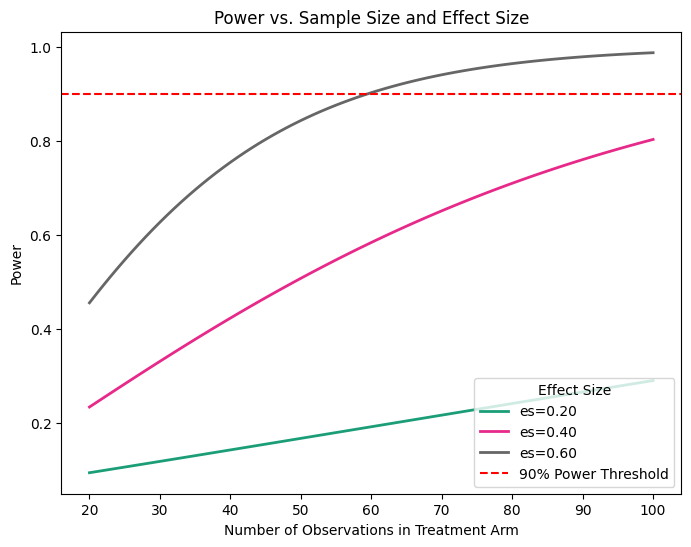

Sample size needed for 90% power with effect size of 0.6: 59


In [43]:
# Create an array for the sample sizes (values from 20 to 100)
sample_sizes = np.arange(20, 101)

# Create an array for the effect sizes (0.2, 0.4, 0.6)
effect_sizes = np.array([0.2, 0.4, 0.6])

# Visualize the power for different sample sizes and effect sizes using plot_power
fig, ax = plt.subplots(figsize=(8, 6))
my_power.plot_power(
    dep_var="nobs", nobs=sample_sizes, effect_size=effect_sizes, alpha=0.05, ax=ax
)
plt.axhline(y=0.9, color="r", linestyle="--", label="90% Power Threshold")
plt.xlabel("Number of Observations in Treatment Arm")
plt.ylabel("Power")
plt.title("Power vs. Sample Size and Effect Size")
plt.legend(title="Effect Size", loc="lower right")
plt.show()

# Calculate the required sample size for 90% power with an effect size of 0.6
required_sample_size = my_power.solve_power(
    effect_size=0.6, alpha=0.05, power=0.9, alternative="two-sided", nobs1=None
)
print(
    "Sample size needed for 90% power with effect size of 0.6:",
    int(required_sample_size),
)

> The above plot presented indicates that for an effect size of 0.6, the power curve surpasses the 90% threshold when the sample size reaches 59 in the treatment group. Consequently, to achieve a power level above 90% with a minimum detectable effect size of 0.6, approximately at least 59 observations would be needed in the treatment arm.

## Extra Credit Extension

### Exercise 9

As noted above, this study actually was conducted, so we know the actual treatment effect. Calculate that treatment effect 3 years after these families first received asset transfers by calculating the difference in `pc_exp_month_el2` between the `treatment == 1` and `treatment == 0` groups.


In [44]:
# Calculate the treatment effect
mean_treatment = household_survey[household_survey["treatment"] == 1][
    "pc_exp_month_el2"
].mean()
mean_control = household_survey[household_survey["treatment"] == 0][
    "pc_exp_month_el2"
].mean()

treatment_effect = mean_treatment - mean_control
print(
    f"The actual treatment effect 3 Years After Asset Transfers is around {treatment_effect:.2f} Per Capita Monthly Expenditures."
)

The actual treatment effect 3 Years After Asset Transfers is around 6.15 Per Capita Monthly Expenditures.


### Exercise 10

What was the statistical power of the actual test? That is, what was the probability, given this effect size and the number of observations in the study, that they would reject the null hypothesis of no effect at alpha=0.05 and given the actual final sample sizes?

In [45]:
# set a parameter, actual effect size
effect_size_actual = treatment_effect / std_pc_exp_month_bl

print(f"The actual effect size is around {effect_size_actual:.4f}")

# Calculate sample size of the treatment and control group
sample_size_treatment = (
    household_survey.loc[household_survey["treatment"] == 1, "pc_exp_month_el2"]
    .notna()
    .sum()
)

print(f"Actual sample size of the treatment group is {sample_size_treatment}")

sample_size_control = (
    household_survey.loc[household_survey["treatment"] == 0, "pc_exp_month_el2"]
    .notna()
    .sum()
)

print(f"Actual sample size of the control group is {sample_size_control}")

# compute the ratio between treatment and controls
control_to_treatment_ratio = sample_size_control / sample_size_treatment

print(
    f"The actual control to treatment ratio is around {round(control_to_treatment_ratio,4)}"
)

The actual effect size is around 0.2536
Actual sample size of the treatment group is 462
Actual sample size of the control group is 405
The actual control to treatment ratio is around 0.8766


In [46]:
# Calculate statistical power
statistical_power = my_power.solve_power(
    effect_size=effect_size_actual,
    nobs1=sample_size_treatment,
    alpha=0.05,
    ratio=control_to_treatment_ratio,
    alternative="two-sided",
)

print(f"The statistical power of the actual test is around {statistical_power:.4f}")

The statistical power of the actual test is around 0.9609


### Exercise 11

What would the power be if Bandhan had only enrolled 200 households per arm? 


In [47]:
# Calculate statistical power with the sample size (200)
statistical_power_200 = my_power.solve_power(
    effect_size=effect_size_actual,
    nobs1=200,
    alpha=0.05,
    ratio=1,
    alternative="two-sided",
)

print(
    f"The statistical power of the test with 200 households per arm is around {round(statistical_power_200,4)}"
)

The statistical power of the test with 200 households per arm is around 0.7155


### Exercise 13

The idea of the "power" of a test is that, when we draw a sample from a population, there's some variation in who happens to end up in that sample. Consequently, even if the *true* effect size in the population is equal to our Minimal Detectable Effect, there's some probability that when we compare treated and untreated outcomes for the $N$ people who actually end up in the study, that Minimal Detectable Effect may not be evident in that sample (at the level of statistical significance $\alpha$ we have chosen).

Given that, one way to think of power is: "If the true effect in the population is our Minimal Detectable Effect, then if I were able to re-run this experiment over and over — drawing new people into the study and testing the difference in outcomes between the control and treated sample each time — then in what percentage of those instances of the experiment would I reject the null hypothesis of no effect?" Power of 80% means that we'd expect to reject the null of no effect in 80% of those many experiments.

Well, we can basically do that thought experiment with this data! 

To do the experiment you did the power calculations for in Exercise 11, we just need to sample 200 observations from the treated group and 200 from the control group, treat that as our experimental sample, and estimate the difference in per capita month expenditures between those two groups (along with the associated p-value).

Then we can repeat that over and over to simulate "re-running" the experiment, each time drawing a new sample of 200 treated observations and 200 control observations. Then we can store the p-values from all these "re-run" experiments and see how often we reject the null of no effect!

Note that when you do this experiment, we have to sample our 200 observations from each treatment arm *with replacement*, just as you would when bootstrapping (if that means anything to you — if it doesn't, don't worry about it). 

So: write a loop where, on each pass, you draw 200 observations (with replacement) from treatment and 200 from control, then calculate the treatment effect and p-value for that sample. Repeat this 10,000 times. 

In what share of cases would you reject the null of no effect at alpha = 0.05?

In [48]:
# Set a random seed for reproducibility
np.random.seed(42)

# Set the parameters
num_runs = 10000
num_rejections = 0

# Initialization for p-value and treatment effect collection
p_values = []
treatment_effects = []

# Perform the simulations
for _ in range(num_runs):
    treatment_sample = np.random.choice(
        household_survey.loc[
            household_survey["treatment"] == 1, "pc_exp_month_el2"
        ].dropna(),
        size=200,
        replace=True,
    )

    control_sample = np.random.choice(
        household_survey.loc[
            household_survey["treatment"] == 0, "pc_exp_month_el2"
        ].dropna(),
        size=200,
        replace=True,
    )
    # Calculate treatment effect and p-value using t-test
    treatment_effect_sim = treatment_sample.mean() - control_sample.mean()
    _, p_value = ttest_ind(treatment_sample, control_sample)

    # Check if the null hypothesis is rejected at alpha = 0.05
    if p_value < 0.05:
        num_rejections += 1

    # Store the treatment effect and p-value for this run
    treatment_effects.append(treatment_effect_sim)
    p_values.append(p_value)

# Calculate the share of cases where the null hypothesis is rejected
share_rejections = num_rejections / num_runs

print(
    f"Share of cases where the null hypothesis is rejected at alpha equals 0.05: {round(share_rejections*100,2)}%"
)

Share of cases where the null hypothesis is rejected at alpha equals 0.05: 53.82%


### Exercise 14

Repeat 11 and 13 with 300 observations per arm.

In [49]:
# Calculate statistical power with the sample size (300)
statistical_power_300 = my_power.solve_power(
    effect_size=effect_size_actual,
    nobs1=300,
    alpha=0.05,
    ratio=1,
    alternative="two-sided",
)

print(
    f"The statistical power of the test with 300 households per arm is around {round(statistical_power_300,4)}"
)

The statistical power of the test with 300 households per arm is around 0.873


In [50]:
# Set a random seed for reproducibility
np.random.seed(42)

# Set the parameters
num_runs = 10000
num_rejections = 0

# Initialization for p-value and treatment effect collection
p_values = []
treatment_effects = []

# Perform the simulations
for _ in range(num_runs):
    treatment_sample = np.random.choice(
        household_survey.loc[
            household_survey["treatment"] == 1, "pc_exp_month_el2"
        ].dropna(),
        size=300,
        replace=True,
    )

    control_sample = np.random.choice(
        household_survey.loc[
            household_survey["treatment"] == 0, "pc_exp_month_el2"
        ].dropna(),
        size=300,
        replace=True,
    )
    # Calculate treatment effect and p-value using t-test
    treatment_effect_sim = treatment_sample.mean() - control_sample.mean()
    _, p_value = ttest_ind(treatment_sample, control_sample)

    # Check if the null hypothesis is rejected at alpha = 0.05
    if p_value < 0.05:
        num_rejections += 1

    # Store the treatment effect and p-value for this run
    treatment_effects.append(treatment_effect_sim)
    p_values.append(p_value)

# Calculate the share of cases where the null hypothesis is rejected
share_rejections = num_rejections / num_runs

print(
    f"Share of cases where the null hypothesis is rejected at alpha equals 0.05: {round(share_rejections*100,2)}%"
)

Share of cases where the null hypothesis is rejected at alpha equals 0.05: 71.2%


### Exercise 15

What did you learn from Exercises 9-14?

>- From exercises 9 through 14, I've learnt the impact of sample size on the statistical power of a study. In general, as sample size increases, the power to detect a true effect and the study's ability to detect meaningful differences also increases.
>- In Exercise 9, the actual treatment effect observed 3 years after families received asset transfers was calculated to be 6.15 Per Capita Monthly Expenditures. This quantifiable benefit underscores the positive impact of the intervention on the economic well-being of the participating households. Exercise 10 revealed that the actual test, based on the original study's design and sample size, had a high statistical power of approximately 0.9609. This indicates a strong probability (over 96%) of correctly rejecting the null hypothesis of no effect when an actual effect exists, underscoring the effectiveness of the study's design in detecting the intervention's impact.
>- Exercise 11 explored a hypothetical scenario of reducing the sample size to 200 households per arm. The statistical power dropped to around 0.7155, and the proportion of simulations rejecting the null hypothesis at an alpha of 0.05 decreased to approximately 53.82%. This illustrates the relationship between sample size and statistical power: as the sample size decreases, the power to detect a true effect also diminishes, reflecting increased uncertainty in the study's findings. 
>- Further analysis in Exercise 14, with an increased sample size of 300 households per arm, showed an improvement in statistical power to around 0.873 and a higher proportion of cases (71.2%) where the null hypothesis of no effect would be rejected. This highlights as sample size increases, the power to detect a true effect and the study's ability to detect meaningful differences also increases.

## Footnotes

1. The poorest households were identified in two steps. First, residents across 120 village hamlets ranked households into five wealth quintiles. Among households ranked in the bottom quintile, Bandhan then verified eligibility per seven criteria: (i) presence of an able-bodied female member (to manage the asset), (ii) no credit access, (iii) landholding below 0.2 acres, (iv) no ownership of productive assets, (v) no able-bodied male member, (vi) presence of school-aged children who were working instead of attending school, and (vii) primary source of income being informal labor or begging. Households had to meet the first two criteria and at least three of the remaining five in order to be eligible for the TUP intervention.
2. The [ethics of randomization in these types of programs](https://www.povertyactionlab.org/resource/ethical-conduct-randomized-evaluations) is subject of a rich literature, and there are currently an extensive set of guidelines used by researchers developing these types of programs.
3. Of the 514 offered the livestock and cash transfers, only 266 accepted. The treatment estimates that follow are thus estimates of the effect of *offering* these transfers. Households that accepted the offers might differ systematically from those that do not, so the study simply compares those *offered* the transfer to those who did not). This is what's called an estimate of the "intention to treat" effect, and is thus *likely* an under-estimate of the effect of cash transfers that would be observed if uptake were greater.